In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [20]:
df = pd.read_csv('cleaned_df_4.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df.dropna(inplace = True)

In [21]:
def assign_month(date):
    if date.month == 1:
        return 0  
    elif date.month == 2:
        return 1  
    elif date.month == 3:
        return 2 
    elif date.month == 4:
        return 3 
    elif date.month == 5:
        return 4 
    elif date.month == 6:
        return 5  
    elif date.month == 7:
        return 6 
    elif date.month == 8:
        return 7  
    elif date.month == 9:
        return 8 
    elif date.month == 10:
        return 9  
    elif date.month == 11:
        return 10 
    else:
        return 11
        
    
df['Month'] = df['pickup_datetime'].apply(assign_month)
df.rename({'shortest_distance_m' : 'Actual_dist'}, axis = 1, inplace = True)
df['Actual_dist'] = df['Actual_dist']/1000
df['Actual_dist_sq'] = df['Actual_dist']**2
df.rename({'distance_km' : 'Haversine_dist'}, axis = 1, inplace = True)
df['Haversine_dist_sq'] = df['Haversine_dist']**2
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time_category,day_category,cab_category,days_passed,Haversine_dist,Actual_dist,travel_time_s,Month,Actual_dist_sq,Haversine_dist_sq
0,9.3,2009-01-01 14:31:47+00:00,-73.998807,40.713696,-73.993580,40.752576,1,2,0,0,0,4.345634,5.108,1190.0,0,26.091664,18.884536
1,10.5,2009-01-01 12:46:00+00:00,-73.962430,40.769807,-73.957583,40.759770,5,2,0,1,0,1.188373,4.027,785.0,0,16.216729,1.412231
2,6.1,2009-01-01 02:46:31+00:00,-73.975759,40.749823,-73.982534,40.738737,1,0,0,0,0,1.358429,1.780,429.0,0,3.168400,1.845330
3,10.1,2009-01-01 10:35:00+00:00,-73.972288,40.761978,-73.984402,40.729590,2,2,0,0,0,3.743181,4.805,1076.0,0,23.088025,14.011401
4,11.0,2009-01-01 02:13:41+00:00,-73.980127,40.737425,-74.009544,40.726025,4,0,0,0,0,2.784022,3.898,957.0,0,15.194404,7.750780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20597,4.9,2009-12-24 04:57:00+00:00,-73.992768,40.758557,-73.981202,40.753625,1,0,0,0,357,1.117955,1.116,383.0,11,1.245456,1.249823
20598,5.7,2009-12-24 09:45:00+00:00,-74.000337,40.742757,-73.991122,40.755898,5,1,0,1,357,1.654604,2.748,613.0,11,7.551504,2.737714
20599,8.9,2009-12-24 21:22:50+00:00,-74.001533,40.735933,-73.991580,40.758903,1,3,0,0,357,2.688245,3.346,887.0,11,11.195716,7.226663
20600,6.1,2009-12-24 09:10:00+00:00,-73.969070,40.791377,-73.982547,40.772078,1,1,0,0,357,2.427490,2.427,433.0,11,5.890329,5.892707


In [22]:
df['time_category'] = 0   # for 11:00 pm - 6:00 am

# 8:00 am - 10:00 am -> 1
df.loc[(df['pickup_datetime'].dt.time >= pd.to_datetime('08:00').time()) &
       (df['pickup_datetime'].dt.time < pd.to_datetime('10:00').time()), 'time_category'] = 1

# 10:00 am - 5:00 pm -> 2
df.loc[(df['pickup_datetime'].dt.time >= pd.to_datetime('10:00').time()) &
       (df['pickup_datetime'].dt.time < pd.to_datetime('17:00').time()), 'time_category'] = 2

# 5:00 pm - 7:00 pm -> 1
df.loc[(df['pickup_datetime'].dt.time >= pd.to_datetime('17:00').time()) &
       (df['pickup_datetime'].dt.time < pd.to_datetime('19:00').time()), 'time_category'] = 1

# 7:00 pm - 11:00 pm -> 3
df.loc[(df['pickup_datetime'].dt.time >= pd.to_datetime('19:00').time()) &
       (df['pickup_datetime'].dt.time < pd.to_datetime('23:00').time()), 'time_category'] = 3

# 6:00 am - 8:00 am -> 1
df.loc[(df['pickup_datetime'].dt.time >= pd.to_datetime('06:00').time()) &
       (df['pickup_datetime'].dt.time < pd.to_datetime('08:00').time()), 'time_category'] = 4


# For getting the weekdays and weekend separation, we have day_category which is
# 0 -> for weekdays
# 1 -> for weekends

df['cab_category'] = df['passenger_count'].apply(lambda x: 2 if x >= 5 else 1)
df.loc[df['passenger_count'] == 1, 'cab_category'] = 0
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time_category,day_category,cab_category,days_passed,Haversine_dist,Actual_dist,travel_time_s,Month,Actual_dist_sq,Haversine_dist_sq
0,9.3,2009-01-01 14:31:47+00:00,-73.998807,40.713696,-73.993580,40.752576,1,2,0,0,0,4.345634,5.108,1190.0,0,26.091664,18.884536
1,10.5,2009-01-01 12:46:00+00:00,-73.962430,40.769807,-73.957583,40.759770,5,2,0,2,0,1.188373,4.027,785.0,0,16.216729,1.412231
2,6.1,2009-01-01 02:46:31+00:00,-73.975759,40.749823,-73.982534,40.738737,1,0,0,0,0,1.358429,1.780,429.0,0,3.168400,1.845330
3,10.1,2009-01-01 10:35:00+00:00,-73.972288,40.761978,-73.984402,40.729590,2,2,0,1,0,3.743181,4.805,1076.0,0,23.088025,14.011401
4,11.0,2009-01-01 02:13:41+00:00,-73.980127,40.737425,-74.009544,40.726025,4,0,0,1,0,2.784022,3.898,957.0,0,15.194404,7.750780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20597,4.9,2009-12-24 04:57:00+00:00,-73.992768,40.758557,-73.981202,40.753625,1,0,0,0,357,1.117955,1.116,383.0,11,1.245456,1.249823
20598,5.7,2009-12-24 09:45:00+00:00,-74.000337,40.742757,-73.991122,40.755898,5,1,0,2,357,1.654604,2.748,613.0,11,7.551504,2.737714
20599,8.9,2009-12-24 21:22:50+00:00,-74.001533,40.735933,-73.991580,40.758903,1,3,0,0,357,2.688245,3.346,887.0,11,11.195716,7.226663
20600,6.1,2009-12-24 09:10:00+00:00,-73.969070,40.791377,-73.982547,40.772078,1,1,0,0,357,2.427490,2.427,433.0,11,5.890329,5.892707


In [23]:
df_encoded = pd.get_dummies(df, columns=['day_category', 'time_category', 'cab_category', 'Month'], drop_first=True)
# Check and convert columns to numeric (especially the target and features)
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values (optional, if missing data exists)
df_encoded.dropna(inplace=True)
df_encoded

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,days_passed,Haversine_dist,Actual_dist,...,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11
0,9.3,1230820307000000000,-73.998807,40.713696,-73.993580,40.752576,1,0,4.345634,5.108,...,0,0,0,0,0,0,0,0,0,0
1,10.5,1230813960000000000,-73.962430,40.769807,-73.957583,40.759770,5,0,1.188373,4.027,...,0,0,0,0,0,0,0,0,0,0
2,6.1,1230777991000000000,-73.975759,40.749823,-73.982534,40.738737,1,0,1.358429,1.780,...,0,0,0,0,0,0,0,0,0,0
3,10.1,1230806100000000000,-73.972288,40.761978,-73.984402,40.729590,2,0,3.743181,4.805,...,0,0,0,0,0,0,0,0,0,0
4,11.0,1230776021000000000,-73.980127,40.737425,-74.009544,40.726025,4,0,2.784022,3.898,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20597,4.9,1261630620000000000,-73.992768,40.758557,-73.981202,40.753625,1,357,1.117955,1.116,...,0,0,0,0,0,0,0,0,0,1
20598,5.7,1261647900000000000,-74.000337,40.742757,-73.991122,40.755898,5,357,1.654604,2.748,...,0,0,0,0,0,0,0,0,0,1
20599,8.9,1261689770000000000,-74.001533,40.735933,-73.991580,40.758903,1,357,2.688245,3.346,...,0,0,0,0,0,0,0,0,0,1
20600,6.1,1261645800000000000,-73.969070,40.791377,-73.982547,40.772078,1,357,2.427490,2.427,...,0,0,0,0,0,0,0,0,0,1


In [24]:
y = df_encoded['fare_amount']
X = df_encoded.drop(['days_passed','passenger_count','fare_amount', 'pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)
X = sm.add_constant(X)  # Add a constant (intercept) term
display(X)
display(y)

,const,Haversine_dist,Actual_dist,travel_time_s,Actual_dist_sq,Haversine_dist_sq,day_category_1,time_category_1,time_category_2,time_category_3,...,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11
0,1.0,4.345634,5.108,1190.0,26.091664,18.884536,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.188373,4.027,785.0,16.216729,1.412231,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.358429,1.780,429.0,3.168400,1.845330,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,3.743181,4.805,1076.0,23.088025,14.011401,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,2.784022,3.898,957.0,15.194404,7.750780,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20597,1.0,1.117955,1.116,383.0,1.245456,1.249823,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20598,1.0,1.654604,2.748,613.0,7.551504,2.737714,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
20599,1.0,2.688245,3.346,887.0,11.195716,7.226663,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
20600,1.0,2.427490,2.427,433.0,5.890329,5.892707,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


0         9.3
1        10.5
2         6.1
3        10.1
4        11.0
         ... 
20597     4.9
20598     5.7
20599     8.9
20600     6.1
20601     9.3
Name: fare_amount, Length: 20602, dtype: float64

In [25]:
X[X.select_dtypes(include=['bool']).columns] = X.select_dtypes(include=['bool']).astype(int)
# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2115.
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:12:30   Log-Likelihood:                -36505.
No. Observations:               20602   AIC:                         7.306e+04
Df Residuals:                   20578   BIC:                         7.325e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.4781      0.06

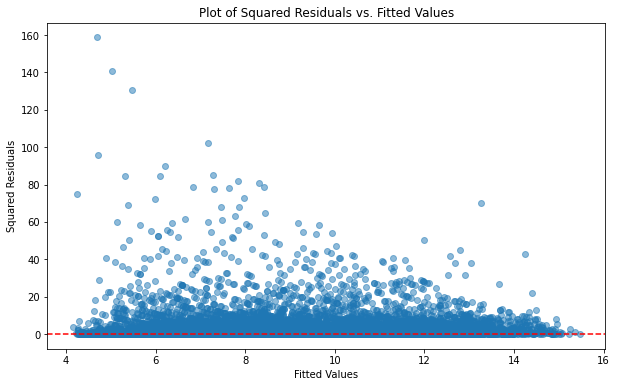

In [26]:
# Plotting squared residuals vs fitted values
fitted_values = model.fittedvalues
residuals = model.resid

# Step 2: Calculate squared residuals
squared_residuals = residuals ** 2

# Step 3: Plot squared residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, squared_residuals, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Squared Residuals')
plt.title('Plot of Squared Residuals vs. Fitted Values')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


In [27]:
# Performing the Goldfeld-Quandt test
# You can specify the split point with the `split` parameter or leave it for default
gq_test = sm.stats.diagnostic.het_goldfeldquandt(y, X, alternative='two-sided')

# Extracting the results
gq_statistic, p_value, _ = gq_test

# Displaying the test results
print("Goldfeld-Quandt Test Statistic:", gq_statistic)
print("p-value:", p_value)

# Interpreting the p-value
if p_value < 0.05:
    print("Evidence of heteroskedasticity (reject null hypothesis).")
else:
    print("No evidence of heteroskedasticity (fail to reject null hypothesis).")


Goldfeld-Quandt Test Statistic: 1.0918424010898955
p-value: 8.4234130137134e-06
Evidence of heteroskedasticity (reject null hypothesis).


In [28]:
# White's test
from statsmodels.stats.diagnostic import het_white

# Getting residuals and exogenous (independent) variables
exog = model.model.exog
residuals = model.resid

# Performing White's test
white_test = het_white(residuals, exog)

# Extracting the results
white_statistic, white_p_value, _, _ = white_test

# Displaying the test results
print("White's Test Statistic:", white_statistic)
print("p-value:", white_p_value)

# Interpretation of the p-value
if white_p_value < 0.05:
    print("Evidence of heteroskedasticity (reject null hypothesis).")
else:
    print("No evidence of heteroskedasticity (fail to reject null hypothesis).")


White's Test Statistic: 948.7622900260127
p-value: 4.6661397757985384e-92
Evidence of heteroskedasticity (reject null hypothesis).


In [29]:
# Check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              Feature        VIF
0               const  42.096288
1      Haversine_dist  54.773427
2         Actual_dist  86.216754
3       travel_time_s   4.344786
4      Actual_dist_sq  60.004221
5   Haversine_dist_sq  43.115141
6      day_category_1   1.057768
7     time_category_1   1.887902
8     time_category_2   2.089434
9     time_category_3   1.905378
10    time_category_4   1.305268
11     cab_category_1   1.052988
12     cab_category_2   1.033798
13            Month_1   1.756230
14            Month_2   1.878877
15            Month_3   1.835594
16            Month_4   1.858211
17            Month_5   1.819506
18            Month_6   1.816903
19            Month_7   1.787684
20            Month_8   1.786923
21            Month_9   1.838095
22           Month_10   1.809560
23           Month_11   1.720948


In [30]:
# Performing Durbin-Watson test
dw_statistic = sm.stats.durbin_watson(model.resid)

# Displaying the test result
print("Durbin-Watson Statistic:", dw_statistic)

# Interpretation of the Durbin-Watson statistic
if dw_statistic < 1.5:
    print("Evidence of positive autocorrelation.")
elif dw_statistic > 2.5:
    print("Evidence of negative autocorrelation.")
else:
    print("No evidence of significant autocorrelation.")


Durbin-Watson Statistic: 1.9680086731040998
No evidence of significant autocorrelation.
